In [1]:
#Import Section
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Loading camera calibration coefficients(matrix and camera coefficients) from pickle file
def getCameraCalibrationCoefficientsFromPickleFile(filePath):
    cameraCalibration = pickle.load( open(filePath, 'rb' ) )
    mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))
    return mtx, dist

def getTestImages(filePath):
    # Load test images.
    testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob(filePath)))
    return testImages

In [3]:
# Load calibration images.
testImages = getTestImages('./test_images/st*.jpg')

#Get mtx and dist
mtx, dist = getCameraCalibrationCoefficientsFromPickleFile('./pickled_data/camera_calibration.p')

In [4]:
def draw_Lines_On_Image(image, vertices):
    original = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(original, mtx, dist, None, mtx)

    color = [255, 0, 0]
    w = 2
    vertice_1 = vertices[0]
    vertice_2 = vertices[1]
    vertice_3 = vertices[2]
    vertice_4 = vertices[3]
    
    
    
    cv2.line(undist, vertice_1, vertice_2, color, w)
    cv2.line(undist, vertice_2, vertice_3, color, w)
    cv2.line(undist, vertice_3, vertice_4, color, w)
    cv2.line(undist, vertice_4, vertice_1, color, w)
    fig, ax = plt.subplots(figsize=(40, 20))
    ax.imshow(undist)

def get_Rectangle_Vertices(image):    
    imgHeight = int(image.shape[0])
    imgWidth = int(image.shape[1])

    vertice_1 = (190, imgHeight)
    vertice_2 = (int(imgWidth/2 - imgWidth*.038), int(imgHeight/2 + imgHeight*.08 + 30))
    vertice_3 = (int(imgWidth/2 + imgWidth*.038), int(imgHeight/2 + imgHeight*.08 + 30))
    vertice_4 = (imgWidth-160, imgHeight)
    vertices = (vertice_1, vertice_2, vertice_3, vertice_4)

    return vertices


def imageSideBySide(leftImg, leftTitle, rightImg, rightTitle, figsize=(20,10) , leftCmap=None, rightCmap=None):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    if leftCmap == None:
        axes[0].imshow(leftImg)
    else:
        axes[0].imshow(leftImg, cmap=leftCmap)
    axes[0].set_title(leftTitle)
    
    if rightCmap == None:
        axes[1].imshow(rightImg)
    else:
        axes[1].imshow(rightImg, cmap=rightCmap)
    axes[1].set_title(rightTitle)

In [5]:
#rectangle_vertices = get_Rectangle_Vertices(testImages[0][1])
#draw_Lines_On_Image(testImages[0][1], rectangle_vertices)

In [6]:
def get_Perspective(img, offset, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)        
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    rectangle_vertices = np.float32(get_Rectangle_Vertices(img)) 

    left1 = rectangle_vertices[0]
    left2 = rectangle_vertices[1]
    right1 = rectangle_vertices[2]
    right2 = rectangle_vertices[3]

    left1_x, left1_y = left1
    left2_x, left2_y = left2
    right1_x, right1_y = right1
    right2_x, right2_y = right2

    src = np.float32([ 
        [left2_x, left2_y],
        [right1_x, right1_y],
        [right2_x, right2_y],
        [left1_x, left1_y]
    ])
    
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    dst = np.float32([
        [offset, 0],
        [img_size[0]-offset, 0],
        [img_size[0]-offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (gray.shape[1], gray.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size)
    return M, Minv, warped

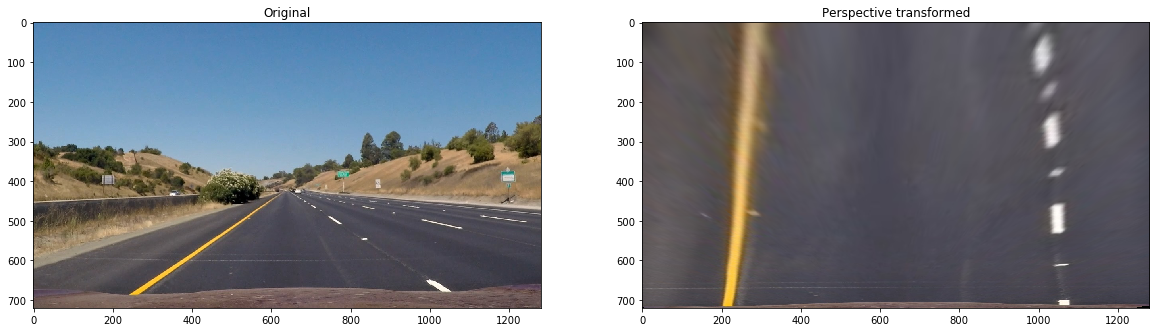

In [7]:
original = cv2.cvtColor(testImages[0][1],cv2.COLOR_BGR2RGB)
M, Minv, warped = get_Perspective(original, 200, mtx, dist)
#imageSideBySide(original, 'Original', warped, 'Perspective transformed')

#Write our results into file
pickle.dump( { 'M': M, 'Minv': Minv }, open('./pickled_data/perspective_transform.p', 'wb'))